# Generating Tabular Data via XGBoost Models with Flow-Matching

This notebook is a self-contained example showing how to train the novel Forest-Flow method to generate tabular data. The idea behind Forest-Flow is to learn Flow-Matching's vector field with XGBoost models instead of neural networks. The motivation is that it is known that Forests work currently better than neural networks on Tabular data tasks. This idea comes with some difficulties, for instance how to approximate Flow Matching's loss, and this notebook shows how to do it on a minimal example. The method, its training procedure and the experiments are described in [(Jolicoeur-Martineau et al. 2023)](https://arxiv.org/abs/2309.09968). The full code can be found [here](https://github.com/SamsungSAILMontreal/ForestDiffusion). 

# Get the data

In [1]:
import uproot
import numpy as np

# Open the ROOT file
files = [
    "/afs/cern.ch/work/a/aguzel/private/bamboo_105/HHtoWWbb_Run3/output/DYestimation-v1.2.8-5/results/Muon_Run2022C.root",
    "/afs/cern.ch/work/a/aguzel/private/bamboo_105/HHtoWWbb_Run3/output/DYestimation-v1.2.8-5/results/Muon_Run2022D.root",
    "/afs/cern.ch/work/a/aguzel/private/bamboo_105/HHtoWWbb_Run3/output/DYestimation-v1.2.8-5/results/Muon_Run2022E.root"
]
# Open all ROOT files and concatenate the arrays from each file
l1_pt_list, l1_eta_list, l1_phi_list, l1_E_list = [], [], [], []
l2_pt_list, l2_eta_list, l2_phi_list, l2_E_list = [], [], [], []

for fname in files:
    file = uproot.open(fname)
    tree = file["DL_resolved_mumu_skim"]
    l1_pt_list.append(tree["l1_pt"].array())
    l1_eta_list.append(tree["l1_eta"].array())
    l1_phi_list.append(tree["l1_phi"].array())
    l1_E_list.append(tree["l1_E"].array())
    l2_pt_list.append(tree["l2_pt"].array())
    l2_eta_list.append(tree["l2_eta"].array())
    l2_phi_list.append(tree["l2_phi"].array())
    l2_E_list.append(tree["l2_E"].array())

n_events = 10000

l1_pt = np.concatenate(l1_pt_list)[:n_events]
l1_eta = np.concatenate(l1_eta_list)[:n_events]
l1_phi = np.concatenate(l1_phi_list)[:n_events]
l1_E = np.concatenate(l1_E_list)[:n_events]
l2_pt = np.concatenate(l2_pt_list)[:n_events]
l2_eta = np.concatenate(l2_eta_list)[:n_events]
l2_phi = np.concatenate(l2_phi_list)[:n_events]
l2_E = np.concatenate(l2_E_list)[:n_events]

# List all branches in the tree
tree = file["DL_resolved_mumu_skim"]

# Read values from a specific branch
l1_pt = tree["l1_pt"].array()[:n_events]
l1_eta = tree["l1_eta"].array()[:n_events]
l1_phi = tree["l1_phi"].array()[:n_events]
l1_E = tree["l1_E"].array()[:n_events]

l2_pt = tree["l2_pt"].array()[:n_events]
l2_eta = tree["l2_eta"].array()[:n_events]
l2_phi = tree["l2_phi"].array()[:n_events]
l2_E = tree["l2_E"].array()[:n_events]

In [2]:
ll = np.array(
    [[l1_pt[i], l1_eta[i], l1_phi[i], l1_E[i], l2_pt[i], l2_eta[i], l2_phi[i], l2_E[i],
      ] for i in range(n_events)]
)

# Compute invariant mass (mll) for each event and append as a new column
def compute_mll_row(row):
    # row: [l1_pt, l1_eta, l1_phi, l1_E, l2_pt, l2_eta, l2_phi, l2_E]
    E1, E2 = row[3], row[7]
    eta1, eta2 = row[1], row[5]
    phi1, phi2 = row[2], row[6]
    pt1, pt2 = row[0], row[4]
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)
    E = E1 + E2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    mll = np.sqrt(max(E**2 - px**2 - py**2 - pz**2, 0))
    return mll

mll = np.apply_along_axis(compute_mll_row, 1, ll)
# ll = np.hstack([ll, mll[:, None]])

# Bin mll in 1 GeV bins and use as category
ll_cat = np.digitize(mll, bins=np.arange(0, np.max(mll) + 1, 0.1)) - 1

# Imports

In [4]:
import copy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher

/afs/cern.ch/work/a/aguzel/private/bamboo_105/pytorch_env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

As example, we use [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 categories of flowers; setosa, versicolor, and virginica).

In [6]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical; 3 categories)
# my_data = load_iris()
# X, y = my_data["data"], my_data["target"]
X=ll
y=ll_cat
# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X), copy.deepcopy(y)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

We set the hyperparameters here.

In [12]:
# Main hyperparameters
n_t = 50  # number of flow steps (higher is better, 50 is enough for great performance)
duplicate_K = 10  # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth = 3
n_estimators = 200
eta = 0.3
tree_method = "hist"
reg_lambda = 0.0
reg_alpha = 0.0
subsample = 1.0

We do the data preprocessing, which includes min/max normalization and extracting the $x(t)$, $y$.

In [13]:
# Save min/max of the values
X_min = np.nanmin(X, axis=0, keepdims=1)
X_max = np.nanmax(X, axis=0, keepdims=1)

# Min-Max scaling of the variables
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Save shape
b, c = X.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X_scaled, (duplicate_K, 1))

# Generate noise data
X0 = np.random.normal(size=X1.shape)

# Saving the frequency of the classes and storing label masks for later
y_uniques, y_probs = np.unique(y, return_counts=True)
y_probs = y_probs / np.sum(y_probs)
mask_y = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y[y_uniques[i]] = np.zeros(b, dtype=bool)
    mask_y[y_uniques[i]][y == y_uniques[i]] = True
    mask_y[y_uniques[i]] = np.tile(mask_y[y_uniques[i]], (duplicate_K))
n_y = len(y_uniques)  # number of classes

In [14]:
# Build [X(t), y] at multiple values of t

# Define Independent Conditional Flow Matching (I-CFM)
FM = ConditionalFlowMatcher(sigma=0.0)

# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Fill with xt and ut
for i in range(n_t):
    t = torch.ones(X0.shape[0]) * t_levels[i]  # current t
    _, xt, ut = FM.sample_location_and_conditional_flow(
        torch.from_numpy(X0), torch.from_numpy(X1), t=t
    )
    X_train[i], y_train[i] = xt.numpy(), ut.numpy()

We train the $ckn_t$ XGBoost models, where $k$ is the number of classes (3), $c$ is the number of input variables (4), and $n_t$ is the number of time levels (50) .

In [32]:
import os

print("Number of CPUs:", os.cpu_count())

Number of CPUs: 28


In [17]:
# Function used for training one model


def train_parallel(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        objective="reg:squarederror",
        eta=eta,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        seed=666,
        tree_method=tree_method,
        device="cpu",
    )

    y_no_miss = ~np.isnan(y_train)
    model.fit(X_train[y_no_miss, :], y_train[y_no_miss])

    return model

In [18]:
%%time

regr = Parallel(n_jobs=-1)(  # using all cpus
    delayed(train_parallel)(
        X_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], :],
        y_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], k],
    )
    for i in range(n_t)
    for j in y_uniques
    for k in range(c)
)

# Replace fits with doubly loops to make things easier
regr_ = [[[None for k in range(c)] for i in range(n_t)] for j in y_uniques]
current_i = 0
for i in range(n_t):
    for j in range(len(y_uniques)):
        for k in range(c):
            regr_[j][i][k] = regr[current_i]
            current_i += 1
regr = regr_

CPU times: user 15min 44s, sys: 2min 2s, total: 17min 46s
Wall time: 14min 4s


We generate data by solving the ODE.

In [19]:
batch_size = n_events  # number of generated samples

In [20]:
# Return the flow at time t using the XGBoost models


def my_model(t, xt, mask_y=None):
    # xt is [b*c]
    xt = xt.reshape(xt.shape[0] // c, c)  # [b, c]

    # Output from the models
    out = np.zeros(xt.shape)  # [b, c]
    i = int(round(t * (n_t - 1)))
    for j, label in enumerate(y_uniques):
        for k in range(c):
            out[mask_y[label], k] = regr[j][i][k].predict(xt[mask_y[label], :])

    out = out.reshape(-1)  # [b*c]
    return out

In [21]:
# Simple Euler ODE solver (nothing fancy)


def euler_solve(x0, my_model, N=100):
    h = 1 / (N - 1)
    x_fake = x0
    t = 0
    # from t=0 to t=1
    for i in range(N - 1):
        x_fake = x_fake + h * my_model(t=t, xt=x_fake)
        t = t + h
    return x_fake

In [22]:
# Generate prior noise
x0 = np.random.normal(size=(batch_size, c))

# Generate random labels for the outcome
label_y_fake = y_uniques[np.argmax(np.random.multinomial(1, y_probs, size=x0.shape[0]), axis=1)]
mask_y_fake = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y_fake[y_uniques[i]] = np.zeros(x0.shape[0], dtype=bool)
    mask_y_fake[y_uniques[i]][label_y_fake == y_uniques[i]] = True

# ODE solve
ode_solved = euler_solve(
    my_model=partial(my_model, mask_y=mask_y_fake), x0=x0.reshape(-1), N=n_t
)  # [t, b*c]
solution = ode_solved.reshape(batch_size, c)  # [b, c]

# invert the min-max normalization
solution = scaler.inverse_transform(solution)

# clip to min/max values
small = (solution < X_min).astype(float)
solution = small * X_min + (1 - small) * solution
big = (solution > X_max).astype(float)
solution = big * X_max + (1 - big) * solution

# Concatenate the y label
Xy_fake = np.concatenate((solution, np.expand_dims(label_y_fake, axis=1)), axis=1)

We just generated fake tabular data! Lets now compare the two dataset (real vs fake).

In [23]:
Xy_true[0:10]  # Real data

array([[ 5.54494057e+01, -1.60363770e+00,  1.33166504e+00,
         1.43399033e+02,  2.49336853e+01, -2.73159027e-01,
        -2.47677612e+00,  2.58699226e+01,  8.81000000e+02],
       [ 5.99670715e+01, -4.99259949e-01,  3.38031769e-01,
         6.75974045e+01,  3.41136208e+01, -6.98760986e-01,
         3.02005005e+00,  4.27864571e+01,  8.85000000e+02],
       [ 4.66906662e+01,  2.28874207e-01,  1.64428711e+00,
         4.79190407e+01,  4.54486694e+01, -4.60002899e-01,
        -8.36517334e-01,  5.03427010e+01,  9.29000000e+02],
       [ 7.04384460e+01, -9.61181641e-01,  2.29528809e+00,
         1.05559990e+02,  2.94874477e+01, -1.13958740e+00,
        -1.36129761e+00,  5.07985725e+01,  8.85000000e+02],
       [ 1.01043953e+02,  1.15782166e+00, -1.94856262e+00,
         1.76683563e+02,  2.07788582e+01,  9.57519531e-01,
         1.36431885e+00,  3.10549145e+01,  9.17000000e+02],
       [ 5.99782524e+01,  1.70492172e-01, -6.54785156e-01,
         6.08521690e+01,  3.62555847e+01, -4.267005

In [24]:
Xy_fake[0:10]  # Flow generated data

array([[ 7.38642073e+01,  3.50545265e-03, -1.61315976e+00,
         9.64285156e+01,  5.29105325e+01,  9.72693577e-01,
         5.04752620e-01,  8.43797946e+01,  8.80000000e+02],
       [ 5.39698996e+01,  1.27273540e-01, -2.49140398e+00,
         6.62947483e+01,  2.58631184e+01,  1.49286721e+00,
         1.45320929e+00,  7.02291073e+01,  8.37000000e+02],
       [ 4.61678400e+01,  1.64940610e+00, -4.47253047e-01,
         1.05105399e+02,  4.01612160e+01,  2.04034410e+00,
         2.24557518e+00,  1.50725063e+02,  9.33000000e+02],
       [ 4.74767872e+01,  7.73933353e-02, -2.90634921e+00,
         4.25504984e+01,  3.47194580e+01, -1.73034202e+00,
        -1.73883091e+00,  9.85582623e+01,  9.02000000e+02],
       [ 4.60190685e+01,  1.61248286e+00,  3.01853543e+00,
         9.69884870e+01,  3.89825516e+01,  7.40581622e-01,
        -2.40836238e+00,  3.95525082e+01,  8.45000000e+02],
       [ 5.41617296e+01, -1.73092993e-01,  2.48617844e+00,
         2.22605745e+02,  2.11701645e+01, -1.009035

In [ ]:
import mplhep as hep

# hep.style.use("CMS")
plt.style.use("default")
plt.rcParams["figure.dpi"] = 400

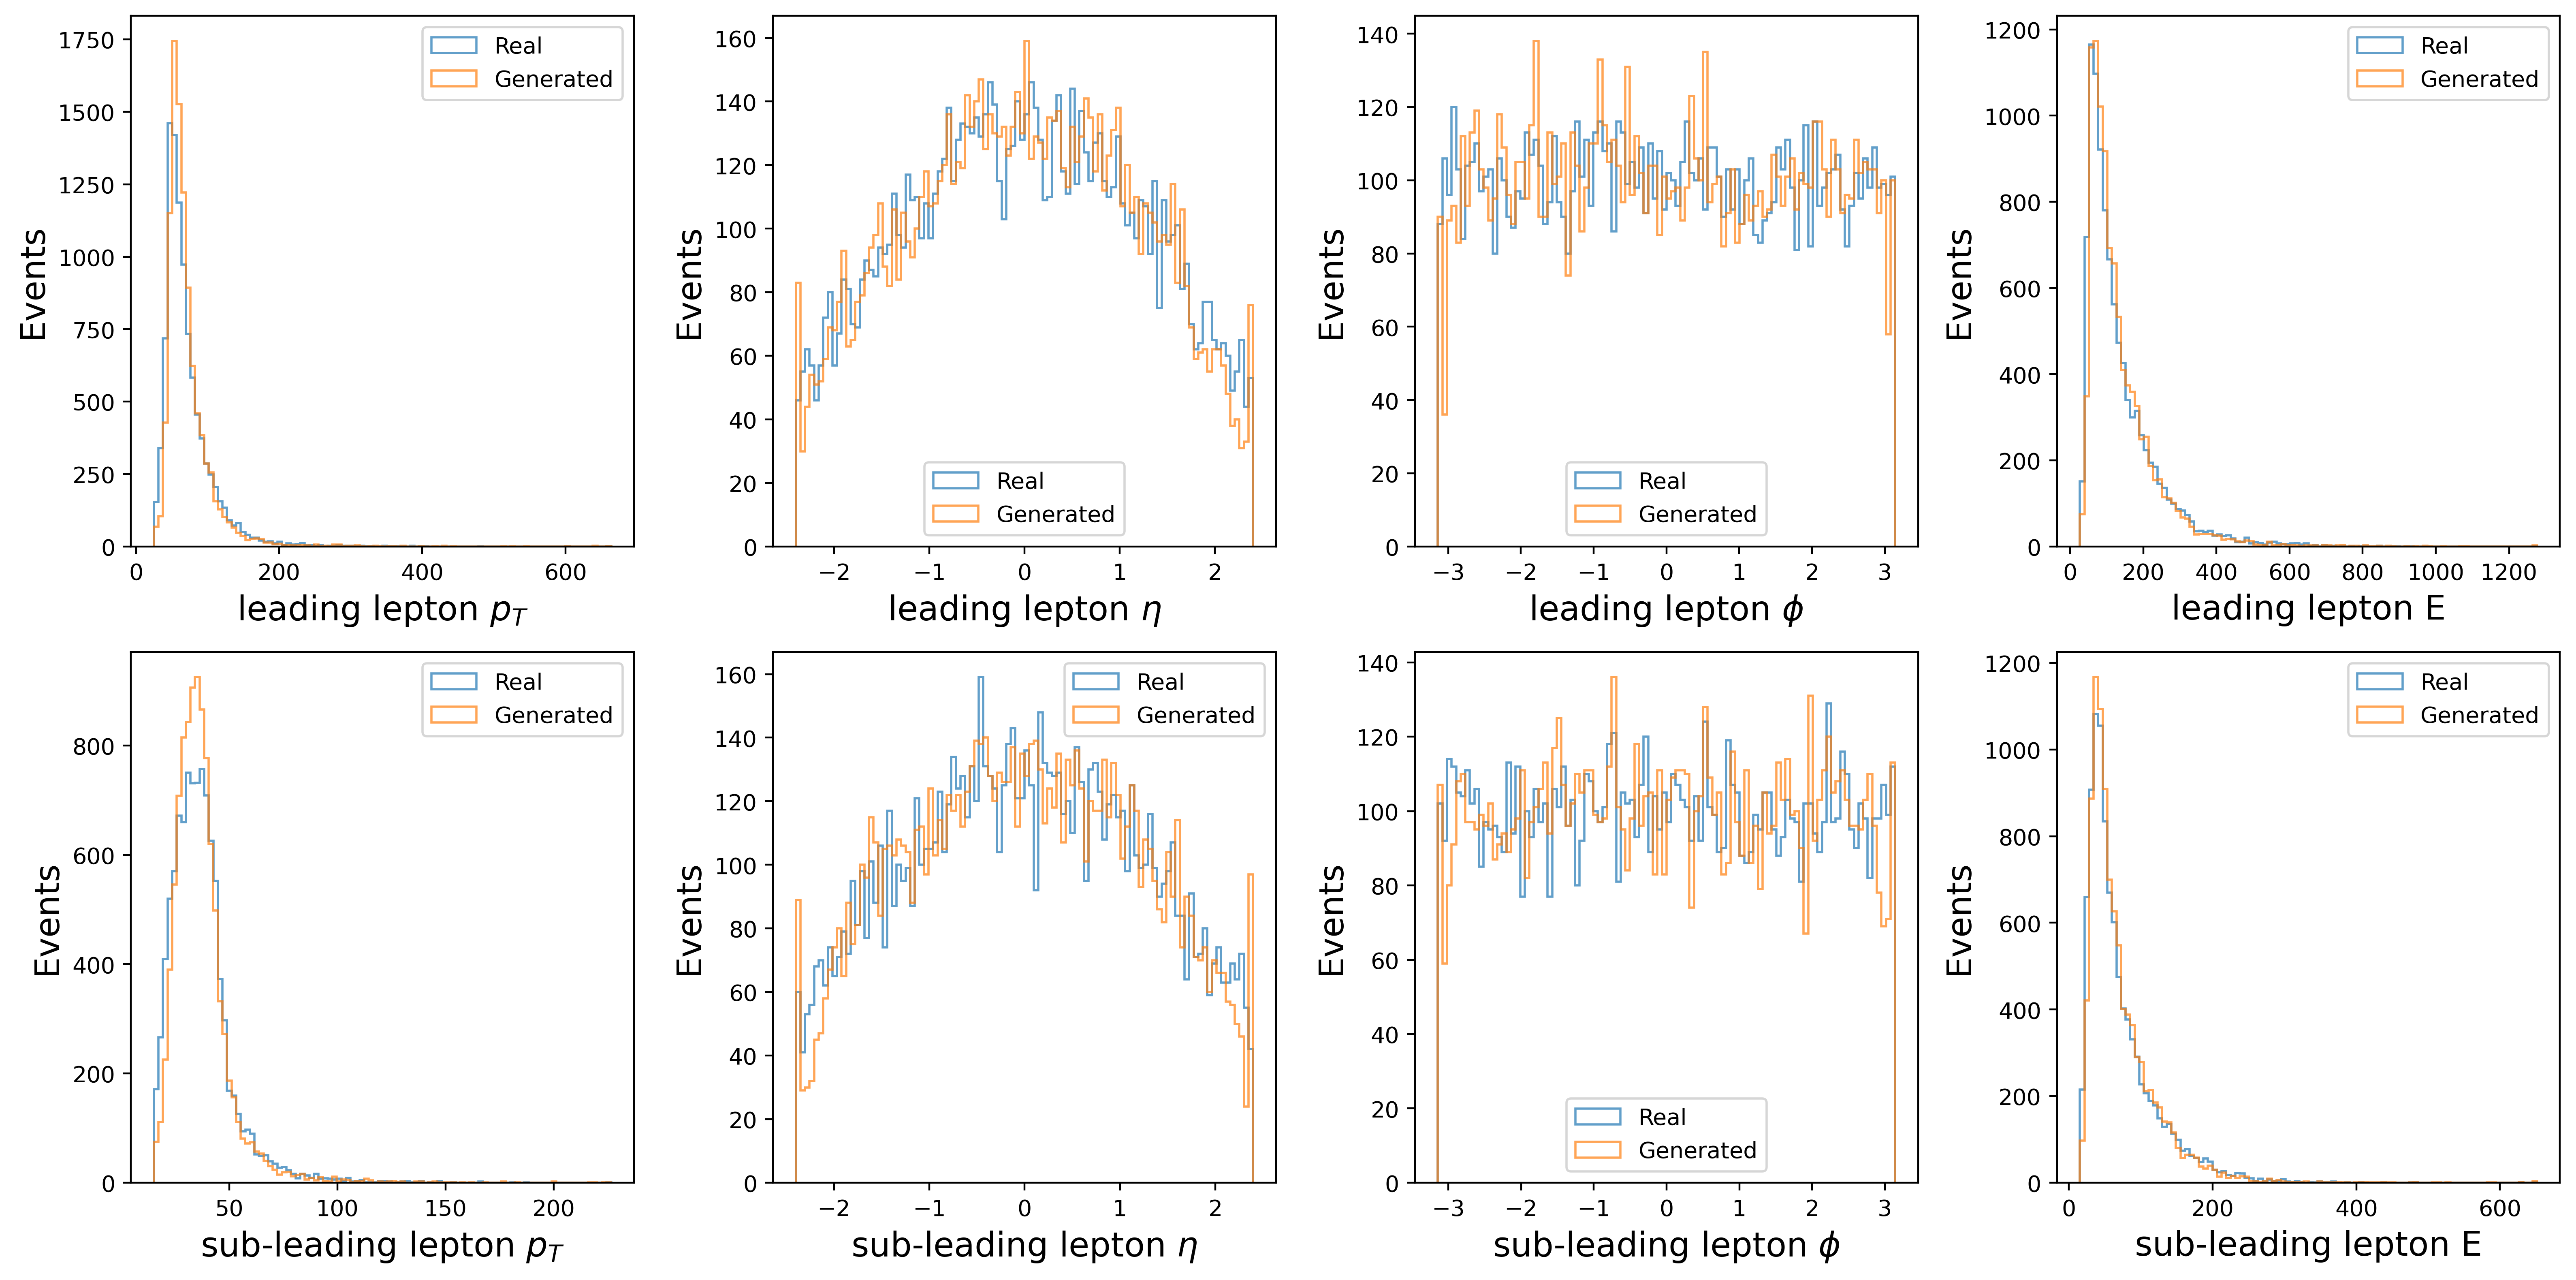

In [72]:
feature_names = [r"$p_T$", r"$\eta$", r"$\phi$", "E"]

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # Real data
    ax = axs[0]
    ax[i].hist(Xy_true[:, i], bins=100, alpha=0.7, histtype="step", label="Real")
    ax[i].hist(Xy_fake[:, i], bins=100, alpha=0.7, histtype="step", label="Generated")
    ax[i].set_xlabel("leading lepton " + feature_names[i], fontsize=15)
    ax[i].set_ylabel("Events", fontsize=15)
    ax[i].legend(fontsize=10)
    # for i in range(4):
    ax = axs[1]
    ax[i].hist(Xy_true[:, i + 4], bins=100, alpha=0.7, histtype="step", label="Real")
    ax[i].hist(
        Xy_fake[:, i + 4], bins=100, alpha=0.7, histtype="step", label="Generated"
    )
    ax[i].set_xlabel("sub-leading lepton " + feature_names[i], fontsize=15)
    ax[i].set_ylabel("Events", fontsize=15)
    ax[i].legend(fontsize=10)
    # ax.set_yscale('log')
plt.tight_layout()
plt.savefig("feature_distributions.png")
plt.show()

Below we show how to do the same with the [ForestDiffusion pip package](https://github.com/SamsungSAILMontreal/ForestDiffusion).

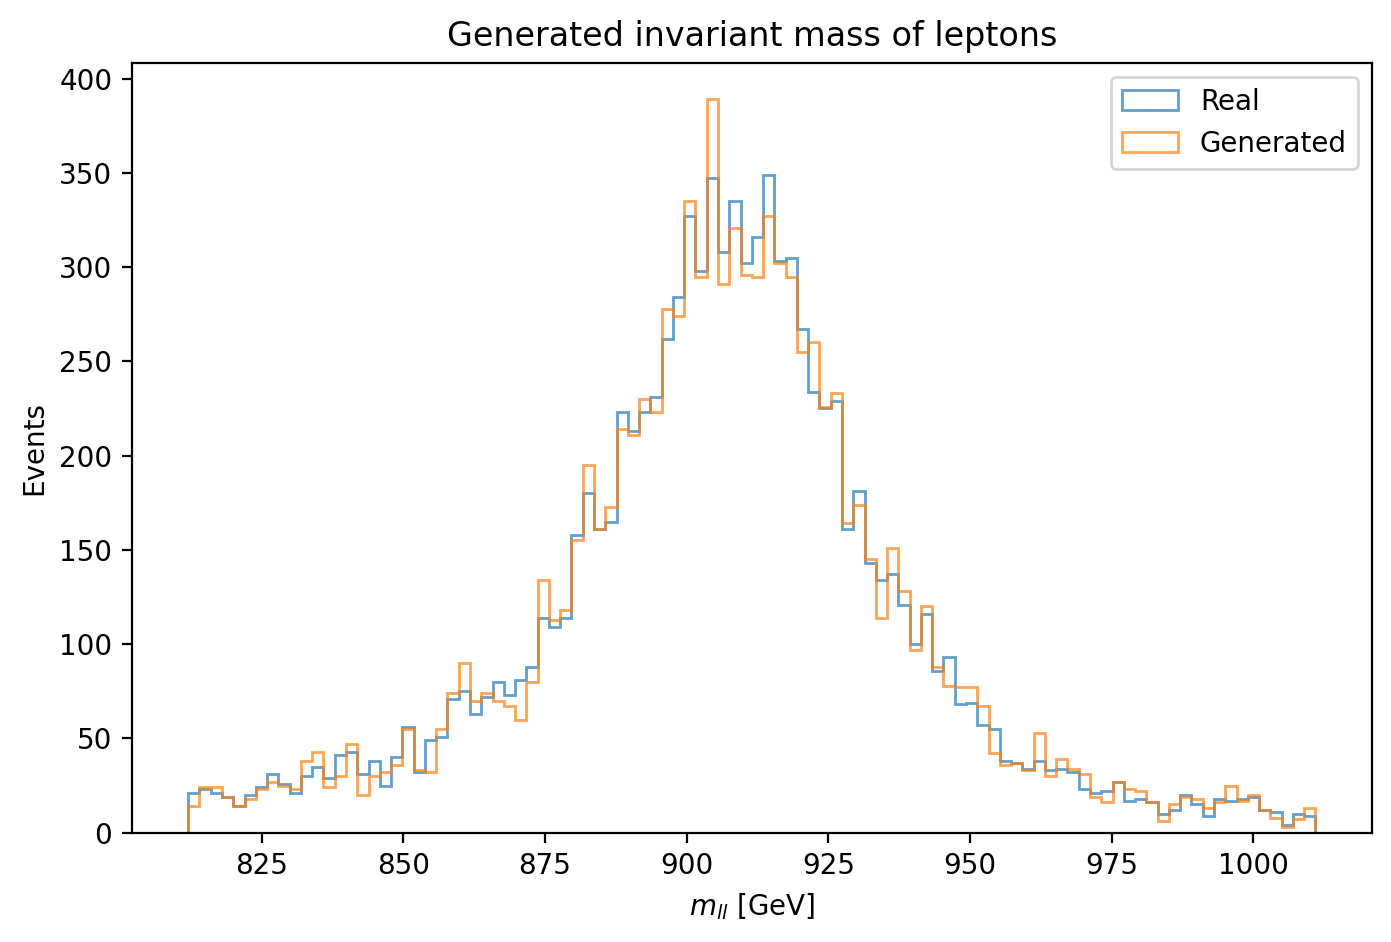

In [69]:
plt.figure(figsize=(8, 5))
plt.hist(Xy_true[:,8], bins=100, alpha=0.7, label='Real', histtype='step')
plt.hist(Xy_fake[:,8], bins=100, alpha=0.7, label='Generated', histtype='step')
plt.ylabel('Count')
plt.gcf().set_dpi(200)
plt.savefig("mll_category_distribution.png", dpi=200)
plt.legend()
plt.xlabel(r'$m_{ll}$ [GeV]')
plt.ylabel('Events')
plt.title('Generated invariant mass of leptons')
plt.show()

In [27]:
def compute_mll_from_leptons(arr):
    # arr shape: (N, 8) -> [l1_pt, l1_eta, l1_phi, l1_E, l2_pt, l2_eta, l2_phi, l2_E]
    E1, E2 = arr[:, 3], arr[:, 7]
    eta1, eta2 = arr[:, 1], arr[:, 5]
    phi1, phi2 = arr[:, 2], arr[:, 6]
    pt1, pt2 = arr[:, 0], arr[:, 4]
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)
    E = E1 + E2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2
    mll = np.sqrt(np.maximum(E**2 - px**2 - py**2 - pz**2, 0))
    return mll

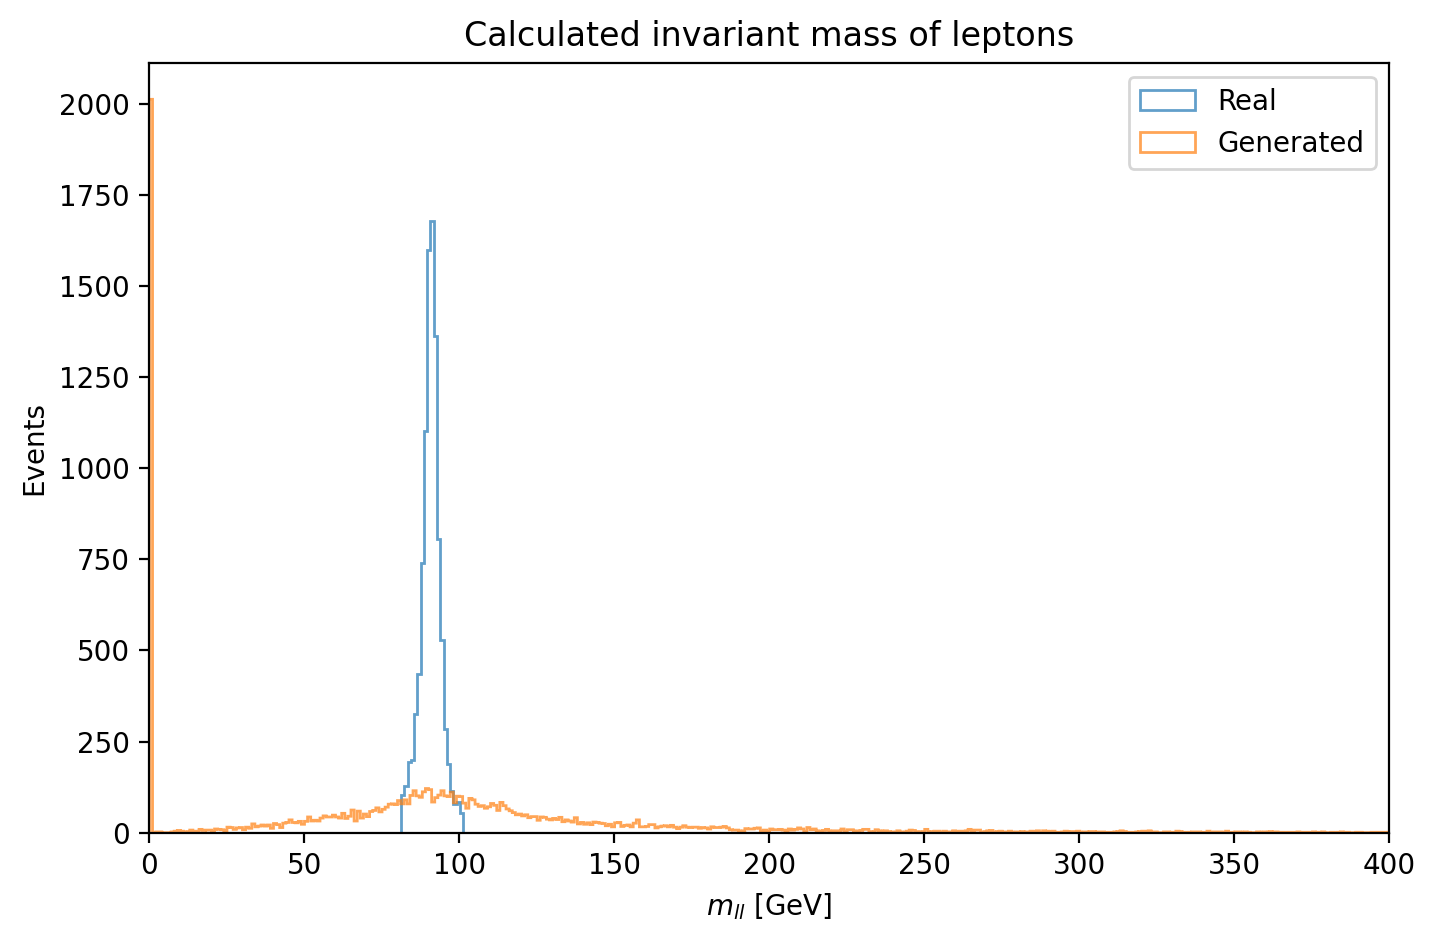

In [71]:
mll_from_X_true = compute_mll_from_leptons(Xy_true[:, :8])
mll_from_X_fake = compute_mll_from_leptons(Xy_fake[:, :8])

bin_true = int(np.max(mll_from_X_true) - np.min(mll_from_X_true).item())
bin_fake = int(np.max(mll_from_X_fake) - np.min(mll_from_X_fake).item())

plt.figure(figsize=(8, 5))
plt.hist(mll_from_X_true, bins=bin_true, alpha=0.7, label='Real', histtype='step')
plt.hist(mll_from_X_fake, bins=bin_fake, alpha=0.7, label='Generated', histtype='step')

plt.xlabel(r'$m_{ll}$ [GeV]')
plt.xlim(0, 400)
plt.gcf().set_dpi(200)
plt.savefig("mll_from_leptons_distribution.png", dpi=200)
plt.ylabel('Events')
plt.legend()
plt.title('Calculated invariant mass of leptons')
plt.show()

In [29]:
# %%time
# from ForestDiffusion import ForestDiffusionModel as ForestFlowModel

# forest_model = ForestFlowModel(
#     X,
#     label_y=y,
#     n_t=n_t,
#     duplicate_K=100,
#     bin_indexes=[],
#     cat_indexes=[],
#     int_indexes=[],
#     diffusion_type="flow",
#     n_jobs=-1,
#     seed=1,
# )
# Xy_fake_ = forest_model.generate(batch_size=X.shape[0])

In [30]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(4):
#     # Real data
#     ax = axs[i]
#     ax.hist(Xy_true[:, i], bins=100, alpha=0.7, histtype='step', label='Real')
#     ax.hist(solution[:, i], bins=100, alpha=0.7, histtype='step', label='Fake')
#     ax.set_xlabel(my_data.feature_names[i])
#     ax.set_ylabel('Count')
#     ax.set_title(f'{my_data.feature_names[i]}')
#     ax.legend()
#     # Remove the second row (axs[1, i]) since both are now combined in one plot
# plt.tight_layout()
# plt.show()
